# The Music of the Sphere: Fourier Series Representation of the Horizon-scale Potential

*Phil Marshall, Laurence Perreault Levasseur and Roger Blandford, August-October 2015*

In this notebook we look at some simulated potential fields, and predict the CMB temperature map from them.

In [1]:
%load_ext autoreload
%autoreload 2


In [15]:
%matplotlib inline
import healpy as hp
import numpy as np
import beatbox


## 1. Generating and Visualizing a 3D Potential

Our plan is to use a simple Fourier series, with terms lying within some sphere in k-space, to represent the potential on horizon scales. Let's instantiate such a "beatbox" universe and generate a Gaussian random potential field in it, using a simple inflation model to generate a power spectrum and then populate the covariance matrix.

In [19]:
We = beatbox.Universe(truncated_nmax=None, truncated_nmin=1, truncated_lmax=30, truncated_lmin=1)
We.generate_a_random_potential_field(high_k_cutoff=We.high_k_cutoff, low_k_cutoff=We.low_k_cutoff, n_s=0.96, kstar=0.02, PSnorm=2.43e-9, Pdist=1, Pmax=np.pi, Pvar=np.pi/8)

Generated  902  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  -0.0 +/- 7.5e-06


Now, let's visualize the 3D potential field, with `yt`. We're trying to make a plot like [this one](http://yt-project.org/doc/_images/vr_sample.jpg), as shown in the [volume rendering tutorial](http://yt-project.org/doc/visualizing/volume_rendering.html). [This `gist` (from Sam Skillman)](https://gist.github.com/samskillman/0e574d1a4f67d3a3b1b1) uses a development version of `yt` to do the rendering, but does show how to use `yt` data structures.

In [ ]:
# !pip install --upgrade Cython
# !pip install --upgrade yt


In [11]:
import yt 

# yt.visualization.color_maps.show_colormaps()


yt : [INFO     ] 2015-12-05 10:48:08,006 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-12-05 10:48:08,006 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2015-12-05 10:48:08,007 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2015-12-05 10:48:08,008 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2015-12-05 10:48:08,009 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2015-12-05 10:48:08,044 Loading field plugins.
yt : [INFO     ] 2015-12-05 10:48:08,045 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-12-05 10:48:08,047 Loaded astro (15 new fields)
yt : [INFO     ] 2015-12-05 10:48:08,049 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-12-05 10:48:08,052 Loaded fluid (64 new fields)
yt : [INFO     ] 2015-12-05 10:48:08,053 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2015-12-05 10:48:08,054 Loaded geometric (112 ne

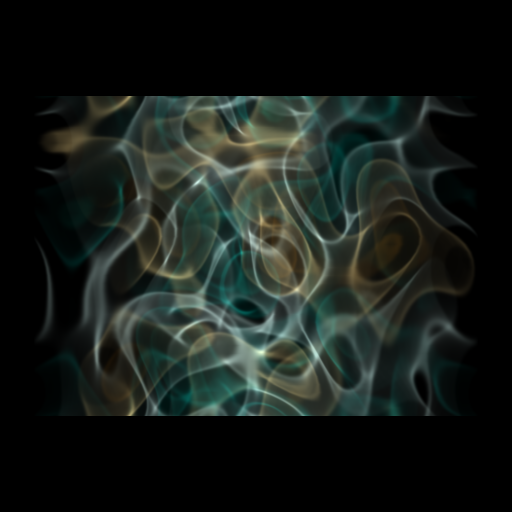

In [5]:
We.show_potential_with_yt(angle=np.pi/2,  N_layer=5, cmap='BrBG', show3D=1)

#from IPython.display import Image
#Image('test1.png',width=400)

In [ ]:
# !pip install --upgrade images2gif
# !pip install --upgrade PIL

In [ ]:
We.show_potential_from_all_angles_with_yt(output='phi6.gif')

In [46]:
from IPython.core.display import Image


In [48]:
Image(url='phi5.gif',width=300)


## 2. Predicting the CMB Temperature Map

When we get to doing the inverse problem, we'll be sampling from the posterior PDF for the potential coefficients $f_n$, and will need to check that these models are indeed plausible. The first model check we will do will be visual, and will involve making mock CMB temperature maps for our model potentials (see [issue 8](https://github.com/rogerblandford/Music/issues/8)).

So, let's convert the Fourier coefficients `fn` into `alm`'s, using the appropriate response matrix:

In [20]:
We.transform_3D_potential_into_alm()


made it to put_alm!!


Apparently hp.Alm.getidx returns negative indices for negative a_lms, the way I'm moving forward is by discarting those negative m indices... Not sure it's the right things to do...

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


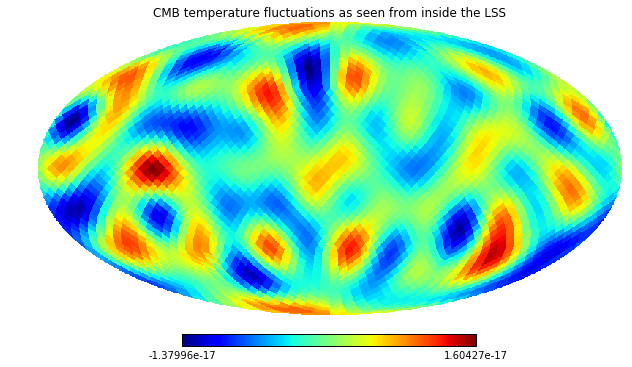

In [18]:
#Simulation with lmax=10
We.show_CMB_T_map(from_perspective_of="observer")

This shows a simulation that included the dipole up to lmax=10. Maybe this is what it should look like? 


When plotting up to lmax=30 it looks a bit wierd, like the power concentrates around lines parallel to the galactic plane... but maybe my eyes are not good for recognizing what it should look like

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


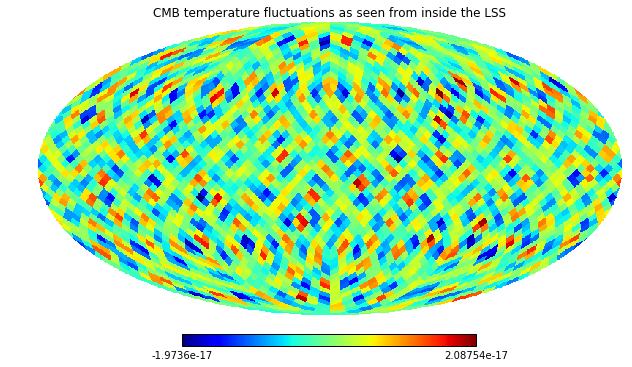

In [21]:
#Simulation with lmax=30
We.show_CMB_T_map(from_perspective_of="observer")